## Load the taxa data, counts

In [1]:
# get rid of the magic if you are having trouble
%matplotlib ipympl
import pandas as pd
import pycircos
import matplotlib.pyplot as plt
import matplotlib
import duckdb as ddb
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path    as mpath
import matplotlib.patches as mpatches
import math
# plt.style.use(['dark_background'])

In [2]:
tax_ranks = ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']

In [3]:
con = ddb.connect("../../data/database.ddb", read_only=True)

In [4]:
# get taxa data
taxa = con.execute("SELECT * FROM taxa").df()

In [5]:
len(taxa)

9536

In [6]:
counts = con.execute("""
    SELECT taxid, COUNT(pid) AS proteins_in_pairs
    FROM proteins 
    WHERE pid IN (SELECT DISTINCT(meso_pid) FROM pairs) 
    OR pid IN (SELECT DISTINCT(thermo_pid) FROM pairs)
    GROUP BY taxid""").df()

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [7]:
counts

,taxid,proteins_in_pairs
0,137838,996
1,52764,307
2,129958,882
3,41988,830
4,83526,539
...,...,...
5023,28099,1127
5024,35517,262
5025,91624,870
5026,36842,1246


In [8]:
taxa = taxa.astype({r : pd.Int64Dtype() for r in tax_ranks[:-1]})

In [9]:
taxa = taxa.merge(counts, on='taxid', how='inner')
taxa

,taxid,16s_seq,16s_len,temperature,superkingdom,phylum,class,order,family,genus,thermophile_label,proteins_in_pairs
0,108150,AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCCTAACA...,1588,65.0,2,1239,186801,68295,186814,1754,True,522
1,64160,AGAGTTTGATCCTGGCTCAGCGCGAACGCTGTCGGCGTGCCTAACA...,1571,70.0,2,200783,187857,1485951,558314,64159,True,384
2,1449,TTTATTGAGAGTTTGATCTTGGCTCAGGATGAACGCTGGCGGCGTG...,1570,37.0,2,1239,91061,1385,186817,29331,False,832
3,1625,AGAGTTTGATNNTGGCTCAGGACGAACGTTGGCGGCGTGCCTAATA...,1570,30.5,2,1239,91061,186826,33958,1578,False,386
4,35787,AGAGTTTGATNNTGGCTCAGGATGAACGCCGGCGGTGTGCCTAATA...,1568,30.0,2,1239,91061,186826,33958,1578,False,488
...,...,...,...,...,...,...,...,...,...,...,...,...
5023,104101,TGAGTTTGATCCTGGCTCAGAGCGAACGCTGGCGGCATGCTTAACA...,1454,28.0,2,1224,28211,204441,433,434,False,516
5024,871651,CCTGGCTCAGAACGAACGCTGGCGGCAGGCCTAACACATGCAAGTC...,1437,25.0,2,1224,28211,204455,31989,1158296,False,973
5025,683354,CATGCAGTCGAACGGCAGCGCGGACTTCGGTCTGGCGGCGAGTGGC...,1410,28.0,2,1224,28216,80840,506,1074468,False,550
5026,191292,AACACGTGGGTGATCTGCCCTGCACTTTGGGATAAGCCTGGGAAAC...,1409,29.0,2,201174,1760,85007,85025,1827,False,419


In [10]:
taxa['thermophile_label'].sum()

289

In [11]:
len(taxa) - taxa['thermophile_label'].sum()

4739

In [12]:
taxa['temperature'].max()

98.0

fill nan taxids with the lower level of taxonomy

In [13]:
reversed_ranks = tax_ranks[::-1]
reversed_ranks[0] = 'taxid'
for i, r in enumerate(reversed_ranks[1:]):
    print(f"{taxa[r].isna().sum()} {r} are missing, filling with {reversed_ranks[i]}")
    taxa[r] = taxa[r].fillna(taxa[reversed_ranks[i]])


18 genus are missing, filling with taxid
78 family are missing, filling with genus
28 order are missing, filling with family
16 class are missing, filling with order
1 phylum are missing, filling with class
0 superkingdom are missing, filling with phylum


In [14]:
pairs = con.execute("""
    SELECT * FROM taxa_pairs WHERE 
    (taxa_pairs.meso_taxid, taxa_pairs.thermo_taxid) IN (SELECT (meso_taxid, thermo_taxid) FROM pairs)""").df()
len(pairs)

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

84024

In [15]:
con.close()

In [16]:
# ncbi scientific names
import json
with open('./snames_map.json') as f:
    snames_map = json.load(f)
new_snames_map = {}
for k, v in snames_map.items():
    new_snames_map[int(k)] = v
snames_map = new_snames_map


In [17]:
import pycircos

## need to modify pycircos chord plot

In [18]:
# try to add alpha
def chord_plot(self, start_list, end_list, facecolor=None, edgecolor=None, linewidth=0.0, alpha=0.2, **kwargs):
    """
    Visualize interrelationships between data.

    Parameters
    ----------
    start_list : tuple
        Start data location of linked data.  
        The tuple is composed of four parameters:

        - `arc_id` : `str`  
            The ID of the first Garc class object to be compared.
            The ID should be in Gcircle object.garc_dict.
        - `edge_position1` : `int`  
            The minimal x coordinates on the Garc class object 
            when the plot is drawn on the rectangular coordinates.
        - `edge_position2` : `int`  
            The maximal x coordinates on the Garc class object 
            when the plot is drawn on the rectangular coordinates.
        - `raxis_position` : `int`  
            The base height for the drawing chord.

    end_list : tuple
        End data location of linked data.  
        The tuple is composed of four parameters:

        - `arc_id` : `str`  
            The ID of the second Garc class object to be compared.
            The ID should be in Gcircle object.garc_dict. 
        - `edge_position1` : `int`  
            The minimal x coordinates on the Garc class object 
            when the plot is drawn on the rectangular coordinates.
        - `edge_position2` : `int`  
            The maximal x coordinates on the Garc class object 
            when the plot is drawn on the rectangular coordinates.
        - `raxis_position` : `int`  
            The base height for the drawing chord.

    facecolor : str or tuple representing color code, optional
        Facecolor of the link. The default is None.
    edgecolor : str or tuple representing color code, optional
        Edge color of the link. The default is "#303030".
    linewidth : float, optional
        Edge line width of the link. The default is 0.0.

    Returns
    -------
    None
    """
    garc_id1 = start_list[0]
    garc_id2 = end_list[0]
    center = 0 

    start1 = self._garc_dict[garc_id1].coordinates[0] 
    end1   = self._garc_dict[garc_id1].coordinates[-1] 
    size1  = self._garc_dict[garc_id1].size - 1
    sstart = start1 + ((end1-start1) * start_list[1]/size1) 
    send   = start1 + ((end1-start1) * start_list[2]/size1)
    stop   = start_list[3] 
    
    start2 = self._garc_dict[garc_id2].coordinates[0] 
    end2   = self._garc_dict[garc_id2].coordinates[-1] 
    size2  = self._garc_dict[garc_id2].size - 1
    ostart = start2 + ((end2-start2) * end_list[1]/size2) 
    oend   = start2 + ((end2-start2) * end_list[2]/size2)
    etop   = end_list[3] 

    if facecolor is None:
        facecolor = Gcircle.colors[self.color_cycle % len(Gcircle.colors)] + "80" 
        self.color_cycle += 1
    
    z1 = stop - stop * math.cos(abs((send-sstart) * 0.5)) 
    z2 = etop - etop * math.cos(abs((oend-ostart) * 0.5)) 
    if sstart == ostart: 
        pass 
    else:
        Path      = mpath.Path
        path_data = [(Path.MOVETO,  (sstart, stop)),
                        (Path.CURVE3,  (sstart, center)),     
                        (Path.CURVE3,  (oend,   etop)),
                        (Path.CURVE3,  ((ostart+oend)*0.5, etop+z2)),
                        (Path.CURVE3,  (ostart, etop)),
                        (Path.CURVE3,  (ostart, center)),
                        (Path.CURVE3,  (send,   stop)),
                        (Path.CURVE3,  ((sstart+send)*0.5, stop+z1)),
                        (Path.CURVE3,  (sstart, stop)),
                    ]
        codes, verts = list(zip(*path_data)) 
        path  = mpath.Path(verts, codes)
        patch = mpatches.PathPatch(path, facecolor=facecolor, linewidth=linewidth, edgecolor=edgecolor, zorder=0, alpha=alpha, **kwargs)
        self.ax.add_patch(patch)

## Build a tree structured dict that tracked counts within head node, including all children node

In [19]:
def build_tree(group, levels, level_index=0, start=0):
    if level_index >= len(levels):
        out_list = group.to_dict(orient='records')
        out = {e['taxid']: e for e in out_list}
        for i, e in enumerate(out.values()):
            e['start'] = start + i
            e['size'] = 1
        return out

    level = levels[level_index]

    # sort by thermophiles and mesophiles
    group = group.sort_values(['thermophile_label', 'proteins_in_pairs'], ascending=False)

    # Build a dictionary for the current level
    tree_dict = {}

    cumulative_size = start
    for level_id, sub_group in group.groupby(level):
        level_dict = {
            'size': len(sub_group),
            'id': level_id,
            'start': cumulative_size,
            'children': build_tree(sub_group, levels, level_index + 1, cumulative_size)
        }

        tree_dict[level_id] = level_dict
        cumulative_size += level_dict['size']

    return tree_dict


In [20]:
nested_data_dict = build_tree(taxa[taxa['superkingdom']==2], ['superkingdom', 'phylum', 'class', 'order', 'family'])
nested_data_dict.update(build_tree(taxa[taxa['superkingdom']!=2], ['superkingdom', 'phylum', 'class', 'order', 'family']))

### add tree structure coloring

In [21]:
from matplotlib import cm
import numpy as np
cmap = cm.get_cmap('BrBG')

/tmp/ipykernel_10397/1171060175.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('BrBG')


In [22]:
import random

def assign_hue(node, r, f, perm, rev):
    # Select the middle hue value in r as the hue value of node v
    node['hue'] = np.mean(r)

    # If 'children' is not a dictionary, we're at a terminal node and done
    if not isinstance(node.get('children', None), dict):
        return

    children = node['children']
    N = len(children)

    # If there are child nodes
    if N > 0:
        total_size = sum(child['size'] for child in children.values())

        # Calculate the proportions for each child
        proportions = [child['size'] / total_size for child in children.values()]

        # Divide r into ranges proportional to the size of each child
        r_parts = np.cumsum([0] + proportions) * (r[1] - r[0]) + r[0]
        ranges = list(zip(r_parts[:-1], r_parts[1:]))

        # If perm, then permute the ranges
        if perm:
            random.shuffle(ranges)

        # If rev, then reverse the even-numbered ranges
        if rev:
            ranges = [ranges[i][::-1] if i % 2 == 0 else ranges[i] for i in range(N)]

        # Reduce each range by keeping its middle fraction f
        ranges = [(r[0] + (r[1] - r[0]) * (1 - f) / 2, r[1] - (r[1] - r[0]) * (1 - f) / 2) for r in ranges]

        # For each child node, recursively assign hue
        for child_node, r_child in zip(children.values(), ranges):
            assign_hue(child_node, r_child, f, perm, rev)

In [23]:
# Let's say that these are the parameters we're going to use
f = 0.9  # middle fraction to keep
perm = False  # whether to permute the ranges
rev = False  # whether to reverse the even-numbered ranges


assign_hue(nested_data_dict[2], (0.0, 0.5), f, perm, rev)
assign_hue(nested_data_dict[2157], (0.5, 1.0), f, perm, rev)

## start with outer garcs

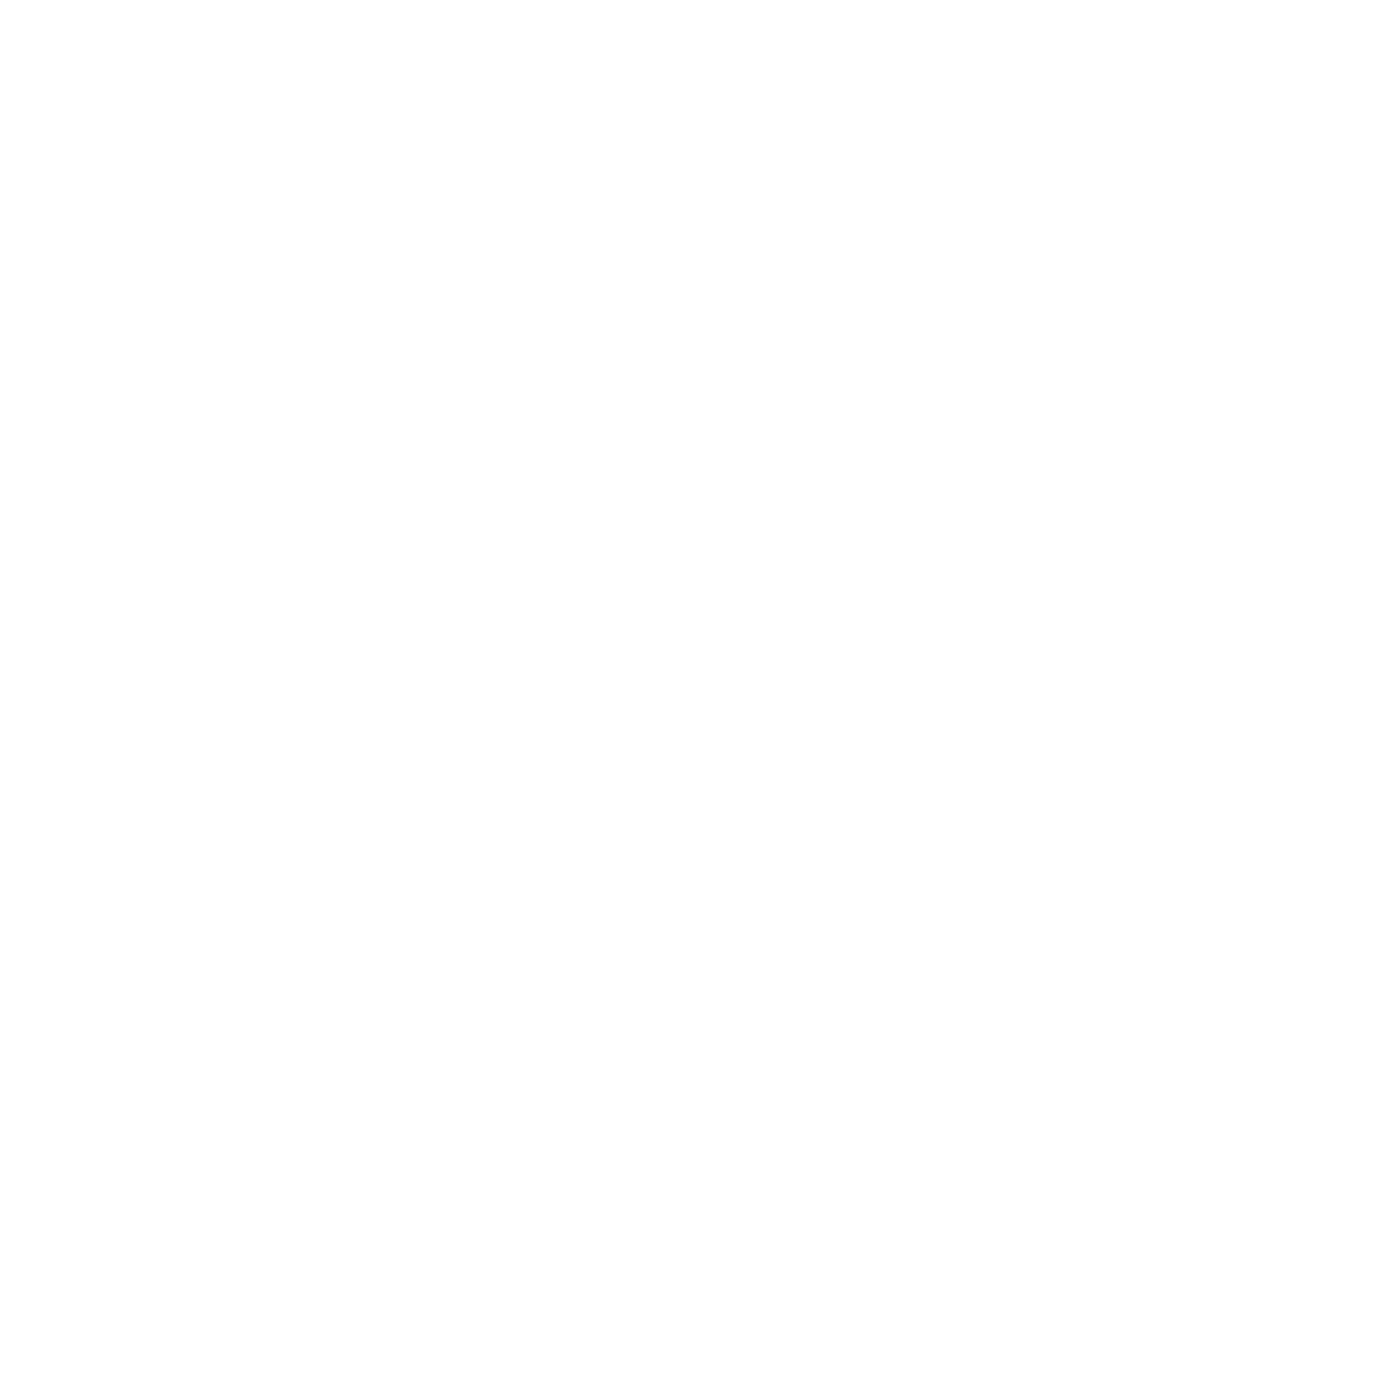

In [24]:
# make a basic plot
#Set chromosomes
circle = pycircos.Gcircle(figsize=(14,14))
for sk_id, sk_dict in nested_data_dict.items():
    arc = pycircos.Garc(
        arc_id=sk_id,
        size=sk_dict['size'],
        interspace=15,
        raxis_range=(900,940),
        label_visible=sk_dict['size'] > 20,
        labelsize=25,
        labelposition=50,
        label= snames_map.get(sk_id, sk_id),
        facecolor=cmap(sk_dict['hue']),
        linewidth=1.5
    )
    circle.add_garc(arc)


In [25]:
circle.set_garcs()

### flatten the data


In [26]:
def extract_all_nodes_flat(dict_):
    out = {}
    for k, v in dict_['children'].items():
        out[k] = v
        if 'children' in v:
            out.update(extract_all_nodes_flat(v))
    return out

In [27]:
flat_data_dict = extract_all_nodes_flat({'children': nested_data_dict})

In [28]:
len(flat_data_dict)

5586

## plot taxa levels

In [29]:
for garc_id in [2, 2157]:
    sk_df = taxa[taxa['superkingdom'] == garc_id]
    ph_ids = sk_df['phylum'].unique()
    positions = [flat_data_dict[p]['start'] for p in ph_ids]
    widths = [flat_data_dict[p]['size'] for p in ph_ids]
    hues = [flat_data_dict[p]['hue'] for p in ph_ids]
    circle.barplot(
        garc_id,
        data=[1]*len(ph_ids),
        positions=positions,
        width=widths,
        facecolor=[cmap(h) for h in hues],
        raxis_range=[850,890],
        linewidth=.75,
    )


#### add labels for large phylum

In [57]:
for phylum_id in taxa['phylum'].values.unique():
    if flat_data_dict[phylum_id]['size'] < 150:
        continue
    else:
        start = flat_data_dict[phylum_id]['start']
        size = flat_data_dict[phylum_id]['size']
        garc_id = 2 if taxa.loc[taxa['phylum'] == phylum_id, 'superkingdom'].values[0] == 2 else 2157

        # convert start and end to garc posisionts
        coords = circle._garc_dict[garc_id].coordinates
        coord_width = coords[1] - coords[0]
        full_size = circle._garc_dict[garc_id].size
        start = coords[0] + (start/full_size * coord_width)
        width = size/full_size * coord_width
        end = start + width

        height    = 40
        bottom    = 800

        rot = (start + end) / 2
        rot = rot*360/(2*np.pi)
        if 90 < rot < 270:
            rot = 180-rot
        else:
            rot = -1 * rot
        height = bottom + height/2 + circle._garc_dict[garc_id].labelposition
        circle.ax.text(start + width/2, height, snames_map[phylum_id], rotation=rot, ha="center", va="center", fontsize=circle._garc_dict[garc_id].labelsize-4, bbox=dict(facecolor='w', alpha=0.4, edgecolor='none'))

#### continue with lower levels

In [30]:
for garc_id in [2, 2157]:
    sk_df = taxa[taxa['superkingdom'] == garc_id]
    ph_ids = sk_df['class'].unique()
    positions = [flat_data_dict[p]['start'] for p in ph_ids]
    widths = [flat_data_dict[p]['size'] for p in ph_ids]
    hues = [flat_data_dict[p]['hue'] for p in ph_ids]
    circle.barplot(
        garc_id,
        data=[1]*len(ph_ids),
        positions=positions,
        width=widths,
        facecolor=[cmap(h) for h in hues],
        raxis_range=[800,840],
        linewidth=.75,
    )


In [31]:
for garc_id in [2, 2157]:
    sk_df = taxa[taxa['superkingdom'] == garc_id]
    ph_ids = sk_df['order'].unique()
    positions = [flat_data_dict[p]['start'] for p in ph_ids]
    widths = []
    for p in ph_ids:
        if 'size' in flat_data_dict[p]:
            widths.append(flat_data_dict[p]['size'])
        else:
            widths.append(1)
    hues = [flat_data_dict[p]['hue'] for p in ph_ids]
    circle.barplot(
        garc_id,
        data=[1]*len(ph_ids),
        positions=positions,
        width=widths,
        facecolor=[cmap(h) for h in hues],
        raxis_range=[750,790],
        linewidth=.75,
    )

In [60]:
for phylum_id in taxa['order'].values.unique():
    if flat_data_dict[phylum_id]['size'] < 200:
        continue
    else:
        start = flat_data_dict[phylum_id]['start']
        size = flat_data_dict[phylum_id]['size']
        garc_id = 2 if taxa.loc[taxa['order'] == phylum_id, 'superkingdom'].values[0] == 2 else 2157

        # convert start and end to garc posisionts
        coords = circle._garc_dict[garc_id].coordinates
        coord_width = coords[1] - coords[0]
        full_size = circle._garc_dict[garc_id].size
        start = coords[0] + (start/full_size * coord_width)
        width = size/full_size * coord_width
        end = start + width

        height    = 40
        bottom    = 700

        rot = (start + end) / 2
        rot = rot*360/(2*np.pi)
        if 90 < rot < 270:
            rot = 180-rot
        else:
            rot = -1 * rot
        height = bottom + height/2 + circle._garc_dict[garc_id].labelposition
        circle.ax.text(start + width/2, height, snames_map[phylum_id], rotation=rot, ha="center", va="center", fontsize=circle._garc_dict[garc_id].labelsize-10, bbox=dict(facecolor='w', alpha=0.4, edgecolor='none'))

## let's make a heatmap of the amount of data being contributed by each species

In [32]:
counts = taxa.set_index('taxid')['proteins_in_pairs'].to_dict()

In [33]:
for garc_id in [2, 2157]:
    sk_df = taxa[taxa['superkingdom'] == garc_id]
    ids = sk_df['taxid'].unique()
    positions = [flat_data_dict[p]['start'] for p in ids]
    widths = [1]*len(positions)
    values = [counts[id_] for id_ in ids]
    vmin = taxa['proteins_in_pairs'].min()
    vmax = taxa['proteins_in_pairs'].max()
    diff = vmax - vmin
    # circle.heatmap(garc_id, data=values, positions=positions, width=widths, vmin=vmin, vmax=vmax, raxis_range=[600,710], cmap=cm.get_cmap('viridis'))
    # circle.scatterplot(garc_id, data=values, positions=positions, rlim=[vmin-0.05*diff, vmax+0.05*diff], raxis_range=[600,710], spine=True, facecolor='#ff9d5c',linewidth=0.0)
    circle.barplot(garc_id, data=values, positions=positions, width=1, raxis_range=[600,710], spine=True, facecolor='#FFB616')
    circle.setspine(garc_id, linewidth=2.0, raxis_range=[600,710])

## add back in the thermo-meso band

In [34]:
for garc_id in [2, 2157]:
    sk_df = taxa[taxa['superkingdom'] == garc_id]
    ids = sk_df['taxid'].unique()
    positions = [flat_data_dict[p]['start'] for p in ids]
    widths = [1]*len(positions)
    values = [1]*len(positions)
    colors = []
    for id_ in ids:
        if flat_data_dict[id_]['thermophile_label']:
            colors.append('#FF1616')
        else:
            colors.append('#96F4FF')
    circle.barplot(
        garc_id, 
        data=values,
        positions=positions,
        width=widths,
        facecolor=colors,
        raxis_range=[555,595]
    )

In [35]:
label_position = circle._garc_dict[2].coordinates[1] + (circle._garc_dict[2].coordinates[1] - circle._garc_dict[2].coordinates[0]) * 0.0005
rot = label_position*360/(2*np.pi)
if 90 < rot < 270:
    rot = 180-rot
else:
    rot = -1 * rot

In [36]:
# protein count labels
circle.ax.text(label_position, 600, f'- {vmin}', rotation=rot, ha="left", va="bottom", fontsize=9)
circle.ax.text(label_position, 710, f'- {vmax}', rotation=rot, ha="left", va="bottom", fontsize=9)
circle.ax.text(label_position, 655, 'Num. proteins', rotation=rot, ha="left", va="bottom", fontsize=9, weight='bold')
# taxa labels
circle.ax.text(label_position, 870, f'Phylum', rotation=rot, ha="left", va="bottom", fontsize=9, weight='bold')
circle.ax.text(label_position, 820, f'Class', rotation=rot, ha="left", va="bottom", fontsize=9, weight='bold')
circle.ax.text(label_position, 770, f'Order', rotation=rot, ha="left", va="bottom", fontsize=9, weight='bold')
# thermophile
circle.ax.text(label_position, 570, f'Mes/Therm', rotation=rot, ha="left", va="bottom", fontsize=9, weight='bold')

Text(5.607746166960372, 570, 'Mes/Therm')

## and the connections

In [37]:
i = 0
for _, row in pairs.iterrows():
    # if np.random.uniform() < 0.95:
    #     continue
    meso_taxid = row['meso_taxid']
    thermo_taxid = row['thermo_taxid']
    # need to get phylum id for this taxid
    meso_garcid = taxa.loc[taxa['taxid'] == meso_taxid, 'superkingdom'].values[0]
    thermo_garcid = taxa.loc[taxa['taxid'] == thermo_taxid, 'superkingdom'].values[0]
    source = (meso_garcid, flat_data_dict[meso_taxid]['start'], flat_data_dict[meso_taxid]['start'] + 1, 554)
    target = (thermo_garcid, flat_data_dict[thermo_taxid]['start'], flat_data_dict[thermo_taxid]['start'] + 1, 554)
    chord_plot(circle, source, target, facecolor='#009614', edgecolor='#009614', linewidth=.3, fill=False, alpha=.006)
    # i += 1
    # if i > 25000:
    #     break

In [38]:
circle.figure.savefig('./circos.png', dpi=600)